In [ ]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 7.2 MB/s 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving YPPAPER.csv to YPPAPER.csv
Saving MOORIMP.csv to MOORIMP.csv
Saving KLEANNARA.csv to KLEANNARA.csv
Saving HSLPAPER.csv to HSLPAPER.csv


In [ ]:
import pandas as pd
import pandas_datareader as pdr
import scipy.stats as stats # zscore
import numpy as np
import csv
import talib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
df_1 = pd.read_csv('YPPAPER.csv', index_col='Date', parse_dates=True)
df_2 = pd.read_csv('MOORIMP.csv', index_col='Date', parse_dates = True)
df_3 = pd.read_csv('KLEANNARA.csv', index_col='Date', parse_dates=True)

In [ ]:
df = pd.read_csv('HSLPAPER.csv', index_col='Date', parse_dates=True)

In [ ]:
def zscore_norm(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        values = stats.zscore(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = values
    return sample_df, eng_list

In [ ]:
df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)

#4.ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [ ]:
df.shape

(1225, 23)

In [ ]:
df_1 = df_1.loc[:,['Close']].copy()
df_1.rename(columns={'Close':'YPPAPER'},inplace=True)
df_2 = df_2.loc[:,['Close']].copy()
df_2.rename(columns={'Close':'MOORIMP'},inplace=True)
df_3 = df_3.loc[:,['Close']].copy()
df_3.rename(columns={'Close':'KLEANNARA'},inplace=True)

df = df.join(df_1,how='left')
df = df.join(df_2,how='left')
df = df.join(df_3,how='left')

In [ ]:
df.shape

(1225, 26)

In [ ]:
df = df.dropna()
df.shape

(1164, 26)

In [ ]:
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
#feature3_list = ['YPPAPER','MOORIMP','KLEANNARA']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

#all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [ ]:
feature3_list = ['YPPAPER','MOORIMP','KLEANNARA']
all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [ ]:
train_from = '2018-07-01'
train_to = '2021-09-01'

val_from = '2021-09-01'
val_to = '2022-03-01'

test_from = '2022-03-01'
test_to = '2022-07-01'

In [ ]:
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [ ]:
target_df = pd.DataFrame({'predict_rtn':[]})

In [ ]:
target_df['predict_rtn'] = df['log_return'].shift(-1)

In [ ]:
print(df.shape, target_df.shape)

(1164, 26) (1164, 1)


In [ ]:
target_df.head()

,predict_rtn
Date,
2017-09-28,0.036701
2017-09-29,-0.012085
2017-10-10,0.015083
2017-10-11,0.005970
2017-10-12,-0.005970


In [ ]:
target_df.tail()

,predict_rtn
Date,
2022-06-27,0.026770
2022-06-28,-0.042396
2022-06-29,-0.011881
2022-06-30,0.023623
2022-07-01,NaN


In [ ]:
train_target_df  = target_df.loc[train_from:train_to,'predict_rtn'].copy()
val_target_df = target_df.loc[val_from:val_to,'predict_rtn'].copy()
test_target_df   = target_df.loc[test_from:test_to,'predict_rtn'].copy()

In [ ]:
print(train_target_df.shape)
print(val_target_df.shape)
print(test_target_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(784,)
(119,)
(83,)
(784, 23)
(119, 23)
(83, 23)


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [ ]:
from tensorflow import keras

In [ ]:
num_unit=200

In [ ]:
train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MA5,MA10,MTM1,MTM3,ROC,WPR,YPPAPER,MOORIMP,KLEANNARA,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,16900.0,17100.0,16400.0,14014.500977,63848,-0.021117,253.383828,282.024519,19021.249390,16458.750610,...,16910.0,17180.0,-350.0,-1100.0,5.806452,-100.000000,3125.0,8310.0,3860.0,-0.029586
2018-07-03,16400.0,16650.0,15650.0,14228.136719,91508,0.015129,284.145022,288.479959,18979.705711,16325.294289,...,16820.0,17080.0,250.0,-150.0,5.714286,-67.213115,3125.0,8500.0,3835.0,0.015244
2018-07-04,16500.0,17050.0,16300.0,14569.953125,60277,0.023740,296.050945,277.442801,18952.221161,16262.778839,...,16730.0,17015.0,400.0,300.0,8.598726,-54.098361,3125.0,8390.0,3900.0,0.033333
2018-07-05,16950.0,17000.0,16100.0,14142.683594,54564,-0.029764,292.104284,259.941018,18892.009003,16142.990997,...,16680.0,16930.0,-500.0,150.0,5.414013,-70.491803,3040.0,8360.0,3890.0,-0.023599
2018-07-06,16450.0,16700.0,16150.0,14185.410156,39004,0.003017,276.471726,248.243863,18794.787461,16060.212539,...,16650.0,16875.0,50.0,-50.0,4.731861,-63.461538,3140.0,8520.0,3920.0,0.009119


In [ ]:
train_df.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'log_return', 'RASD5',
       'RASD10', 'ub', 'lb', 'CCI', 'ATR', 'MACD', 'MA5', 'MA10', 'MTM1',
       'MTM3', 'ROC', 'WPR', 'YPPAPER', 'MOORIMP', 'KLEANNARA', 'next_rtn'],
      dtype='object')

In [ ]:
train_temp, eng_list = zscore_norm(train_df)
print(train_temp.columns, train_temp.shape)
train_temp.head()


Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'log_return', 'RASD5',
       'RASD10', 'ub', 'lb', 'CCI', 'ATR', 'MACD', 'MA5', 'MA10', 'MTM1',
       'MTM3', 'ROC', 'WPR', 'YPPAPER', 'MOORIMP', 'KLEANNARA', 'next_rtn',
       'Open_normal', 'High_normal', 'Low_normal', 'Adj Close_normal',
       'Volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal',
       'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal',
       'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal',
       'WPR_normal', 'YPPAPER_normal', 'MOORIMP_normal', 'KLEANNARA_normal'],
      dtype='object') (784, 45)


,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,YPPAPER_normal,MOORIMP_normal,KLEANNARA_normal
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,16900.0,17100.0,16400.0,14014.500977,63848,-0.021117,253.383828,282.024519,19021.249390,16458.750610,...,-0.733919,0.763293,0.903384,-1.158586,-2.110357,0.379569,-1.767076,-0.696738,1.782516,-0.011082
2018-07-03,16400.0,16650.0,15650.0,14228.136719,91508,0.015129,284.145022,288.479959,18979.705711,16325.294289,...,-0.812982,0.719876,0.854646,0.821069,-0.291783,0.372918,-0.576065,-0.696738,1.887225,-0.029380
2018-07-04,16500.0,17050.0,16300.0,14569.953125,60277,0.023740,296.050945,277.442801,18952.221161,16262.778839,...,-0.773860,0.676460,0.822967,1.315982,0.569648,0.581083,-0.099660,-0.696738,1.826604,0.018196
2018-07-05,16950.0,17000.0,16100.0,14142.683594,54564,-0.029764,292.104284,259.941018,18892.009003,16142.990997,...,-0.848565,0.652339,0.781540,-1.653500,0.282504,0.351247,-0.695166,-0.747536,1.810071,0.010876
2018-07-06,16450.0,16700.0,16150.0,14185.410156,39004,0.003017,276.471726,248.243863,18794.787461,16060.212539,...,-0.885725,0.637867,0.754734,0.161184,-0.100354,0.302018,-0.439785,-0.687774,1.898246,0.032834


In [ ]:
eng_list

['Open_normal',
 'High_normal',
 'Low_normal',
 'Adj Close_normal',
 'Volume_normal',
 'log_return_normal',
 'RASD5_normal',
 'RASD10_normal',
 'ub_normal',
 'lb_normal',
 'CCI_normal',
 'ATR_normal',
 'MACD_normal',
 'MA5_normal',
 'MA10_normal',
 'MTM1_normal',
 'MTM3_normal',
 'ROC_normal',
 'WPR_normal',
 'YPPAPER_normal',
 'MOORIMP_normal',
 'KLEANNARA_normal']

In [ ]:
train_sample_df, eng_list =  zscore_norm(train_df)
val_sample_df, eng_list =  zscore_norm(val_df)
test_sample_df, eng_list = zscore_norm(test_df)

In [ ]:
print(train_sample_df.shape)

(784, 45)


In [ ]:
num_step = 5
num_unit = 200
eng_list = eng_list + feature4_list
n_feature = len(eng_list) - 1

In [ ]:
train_temp[eng_list].head(15)

,Open_normal,High_normal,Low_normal,Adj Close_normal,Volume_normal,log_return_normal,RASD5_normal,RASD10_normal,ub_normal,lb_normal,...,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,YPPAPER_normal,MOORIMP_normal,KLEANNARA_normal,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,0.744601,0.732506,0.632134,0.086659,-0.638628,-1.052894,0.239187,0.581950,1.307462,0.981431,...,0.763293,0.903384,-1.158586,-2.110357,0.379569,-1.767076,-0.696738,1.782516,-0.011082,-0.029586
2018-07-03,0.505378,0.520274,0.265640,0.213378,-0.443228,0.734846,0.496638,0.647626,1.287574,0.918752,...,0.719876,0.854646,0.821069,-0.291783,0.372918,-0.576065,-0.696738,1.887225,-0.029380,0.015244
2018-07-04,0.553222,0.708924,0.583268,0.416128,-0.663855,1.159566,0.596283,0.535337,1.274416,0.889391,...,0.676460,0.822967,1.315982,0.569648,0.581083,-0.099660,-0.696738,1.826604,0.018196,0.033333
2018-07-05,0.768523,0.685343,0.485536,0.162691,-0.704213,-1.479390,0.563252,0.357278,1.245592,0.833131,...,0.652339,0.781540,-1.653500,0.282504,0.351247,-0.695166,-0.747536,1.810071,0.010876,-0.023599
2018-07-06,0.529300,0.543855,0.509969,0.188034,-0.814135,0.137433,0.432418,0.238273,1.199049,0.794253,...,0.637867,0.754734,0.161184,-0.100354,0.302018,-0.439785,-0.687774,1.898246,0.032834,0.009119
2018-07-09,0.624989,0.567437,0.509969,0.086659,-0.514599,-0.609211,0.177104,0.252832,1.174236,0.738754,...,0.637867,0.708434,-0.663673,-1.248927,0.095002,-0.607740,-0.696738,1.705362,0.003557,-0.015015
2018-07-10,0.457533,0.779668,0.583268,0.416128,-0.601851,1.905763,0.014010,0.310183,1.091328,0.751992,...,0.676460,0.705997,2.140838,0.952505,0.531480,0.544569,-0.636977,1.749450,0.084069,0.046012
2018-07-11,0.744601,0.850412,0.778732,0.568192,-0.614998,0.848954,0.253259,0.516162,1.009222,0.780881,...,0.705404,0.698686,0.986040,1.431078,0.569448,1.399794,-0.660882,1.754961,0.080409,0.026627
2018-07-12,0.935980,0.991900,0.925329,0.720254,-0.758962,0.834196,0.661313,0.744100,0.962876,0.800519,...,0.811534,0.740113,0.986040,2.388222,0.510591,1.865510,-0.633989,1.793538,0.065771,0.020231


In [ ]:
def create_dateset_binary(data, feature_list, step, n):
  # x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
  # train_df[정규화된 feature], 정규화된 feature(eng_list), step의 수(5), eng_list의 개수(22) 
    '''
    다음날 시종가 수익률 라벨링.
    '''
    #print("#######", n)
    train_xdata = np.array(data[feature_list[0:n]])
    #print("@@@@@@@@@", train_xdata.shape)
    print("^^^^^^", len(train_xdata))
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    print("m:",len(m))
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))
    
    train_ydata = np.array(data[[feature_list[n]]])
    print(train_ydata.shape)
    print(train_ydata[0:10])
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    print("m:",len(m),"step:",step, len(m+step))
    for i in m + step :
        next_rtn = train_ydata[i][0]
        #print("next_rtn:", next_rtn)
        if next_rtn >= 0.0028 :
            label = 1
        else :
            label = 0
        y.append(label)

    y_batch = np.reshape(np.array(y), (-1,1))
    print(y_batch[0:10])
    print(x_batch.shape, y_batch.shape)
    return x_batch, y_batch

In [ ]:
x_, y_ = create_dateset_binary(train_temp[eng_list], eng_list, num_step, n_feature)

^^^^^^ 784
m: 779
(784, 1)
[[-0.0295858 ]
 [ 0.0152439 ]
 [ 0.03333333]
 [-0.02359882]
 [ 0.00911854]
 [-0.01501502]
 [ 0.04601227]
 [ 0.02662722]
 [ 0.02023121]
 [ 0.00288184]]
m: 779 step: 5 779
[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]]
(779, 5, 22) (779, 1)


In [ ]:
def create_dateset(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))
    
    train_ydata = np.array(data[[feature_list[n]]])
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
      next_rtn = train_ydata[i][0]
      y.append(next_rtn)
    y_batch = np.reshape(np.array(y), (-1,1))
    return x_batch, y_batch

In [ ]:
x_, y_ = create_dateset(train_temp[eng_list], eng_list, num_step, n_feature)
print(y_[0:10])
print(x_.shape, y_.shape)

[[-0.01501502]
 [ 0.04601227]
 [ 0.02662722]
 [ 0.02023121]
 [ 0.00288184]
 [ 0.        ]
 [-0.0173913 ]
 [-0.01449275]
 [ 0.06104651]
 [-0.01634877]]
(779, 5, 22) (779, 1)


In [ ]:
x_train, y_train = create_dateset(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [ ]:
print(x_train.shape, y_train.shape)

(779, 5, 22) (779, 1)


In [ ]:
x_train[0]

array([[ 0.74460108,  0.73250555,  0.63213391,  0.08665871, -0.63862795,
        -1.05289385,  0.23918661,  0.58194991,  1.30746177,  0.98143124,
        -1.18800391,  0.8315983 , -0.73391908,  0.76329296,  0.90338412,
        -1.15858621, -2.11035746,  0.37956917, -1.76707637, -0.69673837,
         1.78251577, -0.01108162],
       [ 0.5053777 ,  0.52027403,  0.26563972,  0.21337785, -0.44322768,
         0.73484559,  0.49663817,  0.64762605,  1.28757389,  0.91875187,
        -1.40358242,  1.07868941, -0.81298239,  0.71987629,  0.85464647,
         0.82106854, -0.29178262,  0.3729177 , -0.57606453, -0.69673837,
         1.8872245 , -0.02937982],
       [ 0.55322238,  0.70892427,  0.58326802,  0.41612801, -0.66385478,
         1.15956572,  0.59628314,  0.53533657,  1.27441642,  0.88939074,
        -0.70270226,  1.16725032, -0.77386012,  0.67645961,  0.82296699,
         1.31598223,  0.56964757,  0.58108346, -0.0996598 , -0.69673837,
         1.82660365,  0.01819551],
       [ 0.76852342

In [ ]:
train_target_df.shape

(784,)

In [ ]:
model = keras.Sequential()


In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM

In [ ]:
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

In [ ]:
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
output_layer = Dense(1)(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])

In [ ]:
#model.add(LSTM(10, batch_input_shape=(784, 5, 22)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

#model.h5 -> -> 

In [ ]:
model = Model(input_layer, output_layer)
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 200)            178400    
                                                                 
 batch_normalization (BatchN  (None, 5, 200)           800       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout (Dropout)           (None, 5, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 200)            320800    
                                                           

In [ ]:
history = model.fit(x_train,y_train,epochs=200, batch_size=5, validation_data=(x_val, y_val))

Epoch 1/200
156/156 [==============================] - 11s 24ms/step - loss: 0.0072 - mae: 0.0250 - val_loss: 0.0088 - val_mae: 0.0138
Epoch 2/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0033 - mae: 0.0195 - val_loss: 8.9116e-04 - val_mae: 0.0227
Epoch 3/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0017 - mae: 0.0183 - val_loss: 6.7217e-04 - val_mae: 0.0220
Epoch 4/200
156/156 [==============================] - 2s 14ms/step - loss: 7.4271e-04 - mae: 0.0198 - val_loss: 0.0012 - val_mae: 0.0250
Epoch 5/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 6.4502e-04 - val_mae: 0.0126
Epoch 6/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0071 - mae: 0.0263 - val_loss: 0.0254 - val_mae: 0.0666
Epoch 7/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0027 - mae: 0.0209 - val_loss: 0.0016 - val_mae: 0.0106
Epoch 8/200
156/156 [========================

In [ ]:
import matplotlib.pyplot as plt

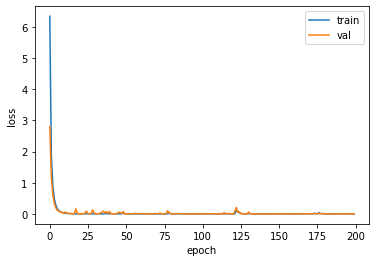

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

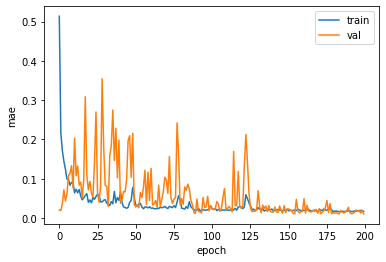

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
predicted = model.predict(x_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)
#cm = confusion_matrix(Y_test, y_pred)
#report = classification_report(Y_test, y_pred)

In [ ]:
print(predicted.shape)
print(y_pred.shape)
print(Y_test.shape)

(78, 1)
(78,)
(78,)


In [ ]:
y_pred = np.argmax(predicted, axis=0)
Y_test = np.argmax(y_test, axis=0)

In [ ]:
print(predicted.shape)
#print(predicted)

(78, 1)


In [ ]:
print(predicted[:][:10])

[[0.00259397]
 [0.00259795]
 [0.00258964]
 [0.00258352]
 [0.00257593]
 [0.00257394]
 [0.00257411]
 [0.00259227]
 [0.00260922]
 [0.0026173 ]]


In [ ]:
print(y_test.shape)

(78, 1)


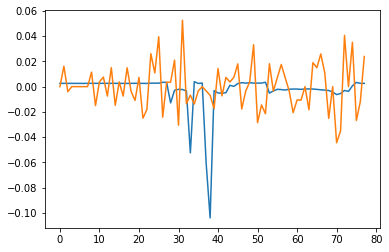

In [ ]:
plt.plot(predicted)
plt.plot(y_test)